In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
def plot_series(time, series, start = 0, end = None, label = None):
    plt.plot(time[start:end], series[start:end], label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope = 0):
    return time * slope

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4, np.cos(season_time * 2*np.pi), 1/np.exp(3 * season_time))

def seasonality(time, period, amplitude = 1, phase = 0):
    season_time = ((time + phase)%period)/period
    return seasonal_pattern(season_time) * amplitude

def white_noise(time, noise_level = 1, seed = None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

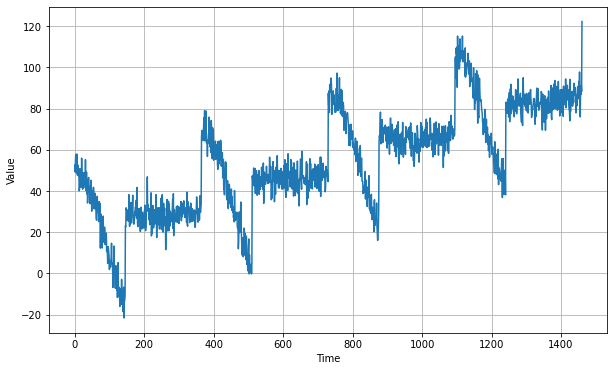

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [14]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# Stateful RNN Forecasting

In [15]:
def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift = window_size, drop_remainder = True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [16]:
for X_batch, y_batch in sequential_window_dataset(tf.range(10), 3):
    print(X_batch.numpy(), y_batch.numpy())

[[[0]
  [1]
  [2]]] [[[1]
  [2]
  [3]]]
[[[3]
  [4]
  [5]]] [[[4]
  [5]
  [6]]]
[[[6]
  [7]
  [8]]] [[[7]
  [8]
  [9]]]


In [8]:
class ResetStatesCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(series, window_size)

model = tf.keras.Sequential()
model.add(tf.keras.layers.SimpleRNN(units = 100, return_sequences = True, stateful = True, batch_input_shape = [1, None, 1]))
model.add(tf.keras.layers.SimpleRNN(units = 100, return_sequences = True, stateful = True))
model.add(tf.keras.layers.Dense(units = 1))
model.add(tf.keras.layers.Lambda(lambda x : x * 200.0))
model.compile(optimizer=tf.keras.optimizers.SGD(lr = 1e-8, momentum=0.9), loss=tf.keras.losses.Huber(), metrics=['mae'])

#Setting lr_scheduler so that it changes every iteraton, to get the optimal learning rate for the optimizer
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 30))

#maing a variable to call the reset class 
reset_states = ResetStatesCallback()
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100
48/48 [==============================] - 2s 11ms/step - loss: 84.7225 - mae: 85.2218
Epoch 2/100
48/48 [==============================] - 0s 10ms/step - loss: 44.0306 - mae: 44.5269
Epoch 3/100
48/48 [==============================] - 0s 10ms/step - loss: 31.8112 - mae: 32.3085
Epoch 4/100
48/48 [==============================] - 0s 10ms/step - loss: 27.6766 - mae: 28.1736
Epoch 5/100
48/48 [==============================] - 0s 10ms/step - loss: 24.7012 - mae: 25.1959
Epoch 6/100
48/48 [==============================] - 0s 10ms/step - loss: 21.8640 - mae: 22.3587
Epoch 7/100
48/48 [==============================] - 0s 10ms/step - loss: 19.5977 - mae: 20.0906
Epoch 8/100
48/48 [==============================] - 0s 10ms/step - loss: 17.7331 - mae: 18.2243
Epoch 9/100
48/48 [==============================] - 0s 10ms/step - loss: 16.4284 - mae: 16.9196
Epoch 10/100
48/48 [==============================] - 0s 10ms/step - loss: 15.5975 - mae: 16.0893
Epoch 11/100
48/48 [=========

48/48 [==============================] - 1s 10ms/step - loss: 18.2958 - mae: 18.7878
Epoch 85/100
48/48 [==============================] - 0s 10ms/step - loss: 25.4487 - mae: 25.9437
Epoch 86/100
48/48 [==============================] - 0s 10ms/step - loss: 32.5890 - mae: 33.0872
Epoch 87/100
48/48 [==============================] - 0s 10ms/step - loss: 30.8899 - mae: 31.3876
Epoch 88/100
48/48 [==============================] - 0s 10ms/step - loss: 19.2671 - mae: 19.7602
Epoch 89/100
48/48 [==============================] - 0s 10ms/step - loss: 32.8940 - mae: 33.3907
Epoch 90/100
48/48 [==============================] - 0s 10ms/step - loss: 37.0275 - mae: 37.5246
Epoch 91/100
48/48 [==============================] - 0s 10ms/step - loss: 36.2031 - mae: 36.7005
Epoch 92/100
48/48 [==============================] - 0s 10ms/step - loss: 32.1857 - mae: 32.6840
Epoch 93/100
48/48 [==============================] - 0s 10ms/step - loss: 36.9620 - mae: 37.4595
Epoch 94/100
48/48 [=============

(1e-08, 0.0001, 0.0, 30.0)

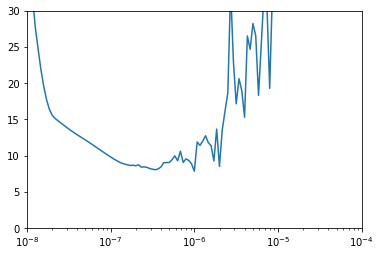

In [11]:
#Here we willl se at which learning rate point the graph becomes un-consistant
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [17]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.SimpleRNN(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
 tf.keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
33/33 [==============================] - 2s 23ms/step - loss: 60.2497 - mae: 60.7476 - val_loss: 25.0215 - val_mae: 25.5176
Epoch 2/500
33/33 [==============================] - 0s 13ms/step - loss: 21.4714 - mae: 21.9618 - val_loss: 10.9142 - val_mae: 11.4074
Epoch 3/500
33/33 [==============================] - 0s 13ms/step - loss: 18.7249 - mae: 19.2167 - val_loss: 12.0569 - val_mae: 12.5479
Epoch 4/500
33/33 [==============================] - 0s 13ms/step - loss: 17.5231 - mae: 18.0143 - val_loss: 10.4488 - val_mae: 10.9391
Epoch 5/500
33/33 [==============================] - 0s 14ms/step - loss: 16.6983 - mae: 17.1891 - val_loss: 9.9581 - val_mae: 10.4499
Epoch 6/500
33/33 [==============================] - 0s 14ms/step - loss: 15.9090 - mae: 16.3984 - val_loss: 9.1539 - val_mae: 9.6415
Epoch 7/500
33/33 [==============================] - 0s 14ms/step - loss: 15.2155 - mae: 15.7027 - val_loss: 8.3393 - val_mae: 8.8249
Epoch 8/500
33/33 [==============================] - 

33/33 [==============================] - 0s 12ms/step - loss: 7.5705 - mae: 8.0485 - val_loss: 7.2326 - val_mae: 7.7193
Epoch 63/500
33/33 [==============================] - 0s 12ms/step - loss: 7.5344 - mae: 8.0126 - val_loss: 7.2253 - val_mae: 7.7120
Epoch 64/500
33/33 [==============================] - 0s 12ms/step - loss: 7.5009 - mae: 7.9792 - val_loss: 7.2330 - val_mae: 7.7198
Epoch 65/500
33/33 [==============================] - 0s 12ms/step - loss: 7.4706 - mae: 7.9491 - val_loss: 7.2638 - val_mae: 7.7507
Epoch 66/500
33/33 [==============================] - 0s 14ms/step - loss: 7.4424 - mae: 7.9210 - val_loss: 7.3071 - val_mae: 7.7941
Epoch 67/500
33/33 [==============================] - 1s 16ms/step - loss: 7.4135 - mae: 7.8922 - val_loss: 7.3386 - val_mae: 7.8257
Epoch 68/500
33/33 [==============================] - 0s 13ms/step - loss: 7.3803 - mae: 7.8593 - val_loss: 7.3363 - val_mae: 7.8234
Epoch 69/500
33/33 [==============================] - 0s 13ms/step - loss: 7.3444 

In [18]:
model = tf.keras.models.load_model("my_checkpoint.h5")

In [22]:
model.reset_states()
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time - 1:-1, 0]

In [23]:
rnn_forecast.shape

(461,)

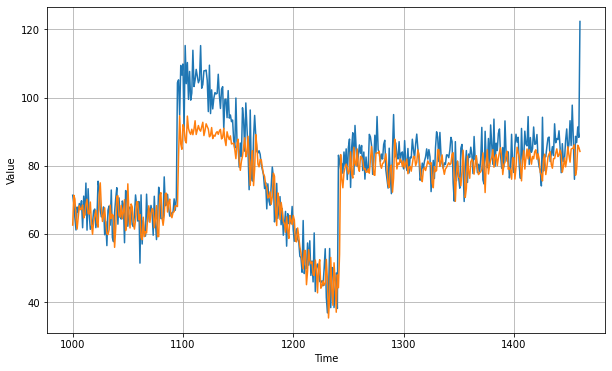

In [24]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [26]:
error = tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()
error

6.2778406